Loading both of our models here and testing them together. Most of these script are already used elsewhere but they are necessary to be able to predict images based on our predicted exposure.

Hyperparameters which can easily be changed.

In [1]:
HEIGHT = 64
WIDTH = 64

Here are all the imports.

In [2]:
import os
import skimage.io as io
import skimage.transform as trasns

from keras.models import *

import rawpy
import cv2
import numpy as np
from numpy import genfromtxt

import time
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from PIL import Image
import pandas
from sklearn.preprocessing import StandardScaler

The paths to the directories

In [3]:
trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
replaceString = "/home/takats_balint1/deephf/data"

This function returns tuple, consisting of the raw, and its ground truth pair paths'

In [4]:
def LoadData(path):
    Data = []
    with open(path) as File:
        for line in File:
            data, truth, _, _ = line.split()
            data = data.replace(".", replaceString, 1)
            truth = truth.replace(".", replaceString, 1)
            # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
            Data.append([data, truth])
    print (len(Data))
    return Data

In [5]:
trainData = LoadData(trainPath)
valData = LoadData(valPath)
testData = LoadData(testPath)

1865
234
598


We already used these functions in the ExposureScript that is the reason why there are no comments about them here.

In [6]:
def fixFile(file):
    return file.replace("data", "smalldata").replace("ARW", "csv")

def loadFile(file):
    good = fixFile(file)
    data = genfromtxt(good, delimiter=',')
    return data.reshape((HEIGHT, WIDTH,3))

def Ratio(in_path, truth_path):
    in_exposure = float(in_path[53:-5])
    gt_exposure = float(truth_path[52:-5])
    ratio = min(gt_exposure / in_exposure, 300)
    return ratio

In [7]:
def train_Data():
    trainPermutation = np.random.permutation(len(trainData))
    data = [None] * len(trainData)
    truth = [None] * len(trainData)
    
    start_time = time.time()
    
    for i in range(0, len(trainPermutation)):
        ratio = Ratio(trainData[trainPermutation[i]][0], trainData[trainPermutation[i]][1])
        truth[i] = ratio
        raw = loadFile(trainData[trainPermutation[i]][0])
        data[i] = raw
        
    load_end_time = time.time()
    
    print("Train data load time taken: " + str(load_end_time-start_time))
    
    return np.array(data), np.array(truth)


def val_Data():
    valPermutation = np.random.permutation(len(valData))
    val_data = [None] * len(valData)
    val_truth = [None] * len(valData)
    
    start_time = time.time()
    
    for i in range(0, len(valPermutation)):
        ratio = Ratio(valData[valPermutation[i]][0], valData[valPermutation[i]][1])
        val_truth[i] = ratio
        raw = loadFile(valData[valPermutation[i]][0])
        val_data[i] = raw
        
    load_end_time = time.time()
    
    print("Validation data load time taken: " + str(load_end_time-start_time))
    
    return np.array(val_data), np.array(val_truth)


def test_Data():
    testPermutation = np.random.permutation(len(testData))
    test_data = [None] * len(testData)
    test_truth = [None] * len(testData)
    
    start_time = time.time()
    
    for i in range(0, len(testPermutation)):
        ratio = Ratio(testData[testPermutation[i]][0], testData[testPermutation[i]][1])
        test_truth[i] = ratio
        raw = loadFile(testData[testPermutation[i]][0])
        test_data[i] = raw
        
    load_end_time = time.time()
    
    print("Test data load time taken: " + str(load_end_time-start_time))
    
    return np.array(test_data), np.array(test_truth)

Loading all the data

In [8]:
data, truth = train_Data()
val_data, val_truth = val_Data()
test_data, test_truth = test_Data()

Train data load time taken: 382.0423150062561
Validation data load time taken: 47.94442009925842
Test data load time taken: 121.65865969657898


Normalizing

In [9]:
truth = truth.reshape(-1, 1)
val_truth = val_truth.reshape(-1, 1)

scaler = StandardScaler()
truth = scaler.fit_transform(truth)
val_truth = scaler.fit_transform(val_truth)

Here we merge the TrainScript and the ExposureScipt models and predicting images based on our own predicted exposures.

In [10]:
raw = rawpy.imread(testData[0][0])

raw = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
raw = np.expand_dims(np.float32(raw / 65535.0), axis=0)
print("Data loaded...")
input_patch = np.minimum(raw, 1.0)

Model = load_model('exposure_model')
MainModel = load_model('my_model')
print("Model loaded...")

predictedRatio = scaler.inverse_transform(Model.predict(test_data[:1]))

input_patch_pred = np.array(raw)*predictedRatio

input_patch_truth = raw*Ratio(testData[0][0],testData[0][1])

print("Predicting...")
test_out1 = MainModel.predict(input_patch_truth)
test_out2 = MainModel.predict(input_patch_pred)
print("Prediction ready")
test_out1 = ((np.minimum(np.maximum(0, test_out1),1)*255)).astype(int)
test_out1 = test_out1.reshape(test_out1.shape[1], test_out1.shape[2], test_out1.shape[3])

test_out2 = ((np.minimum(np.maximum(0, test_out2),1)*255)).astype(int)
test_out2 = test_out2.reshape(test_out2.shape[1], test_out2.shape[2], test_out2.shape[3])

Data loaded...
Model loaded...
Predicting...
Prediction ready


Displaying predictions with inputs: test image with true exposure, test image with our exposure, test truth image and test image with postprocess.

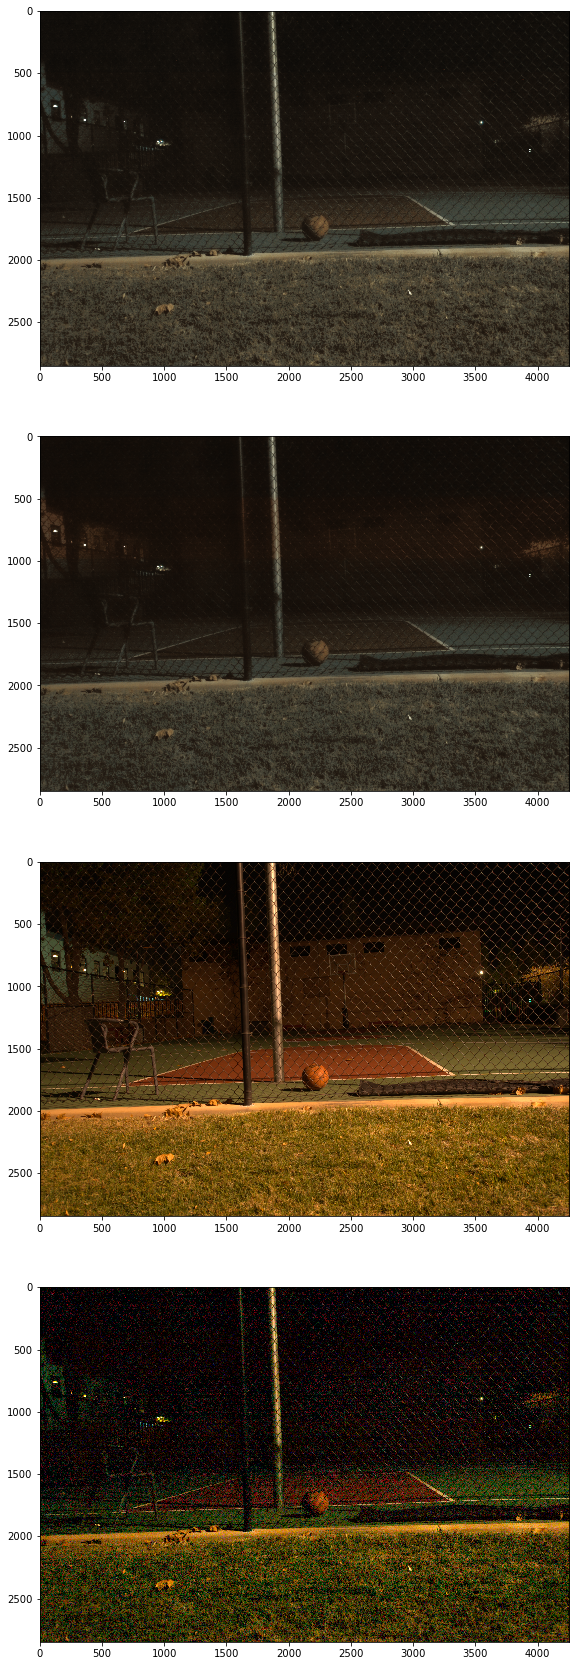

In [11]:
test_truth = rawpy.imread(testData[0][1])
test_truth = test_truth.postprocess()

test_ori = rawpy.imread(testData[0][0])
test_ori = test_ori.postprocess()

fig, axes = plt.subplots(4,1, figsize=(30,30))
axes[0].imshow(test_out1, interpolation='nearest')
axes[1].imshow(test_out2, interpolation='nearest')
axes[2].imshow(test_truth, interpolation='nearest')
axes[3].imshow(test_ori, interpolation='nearest')
plt.show()